In [53]:
# auto-reload edited modules
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.insert(0, "/home/mmurakami/crios_backups/an_helper_functions")

# run the script into the current kernel (vars/functions become available)
%run -i "/home/mmurakami/crios_backups/an_helper_functions/load_packages.py"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [54]:
# set the parameters for the astxfe 90 grid
nx = 90
ncut1 = 150
ncut2 = 60
ny = 2*ncut1 + nx + ncut2
nz = 50
nfx = np.array([nx,0,nx,ncut2,ncut1])
nfy = np.array([ncut1, 0, nx,nx,nx])

In [55]:
dirroot = "/scratch3/atnguyen/aste_90x150x60/"
dirgrid = dirroot + "GRID_real8/"
dirgridnb = dirroot + "GRID_noblank/"
runstr= "run_c68v_heffmosm3x_layers_lessmem1_viscAHp5em2_it0000_pk0000000001/"
layers_path = dirroot + runstr
extL = "LAYERS"
dirmask = dirroot + "run_template/input_maskTransport/"
dirdiags = layers_path + "diags/BUDG/"
dirstate = layers_path + "diags/STATE/"

In [56]:
# 126-130
xc = mygrid['XC']
yc = mygrid['YC']
rac = mygrid['RAC']
drf = mygrid['DRF']

In [57]:
nx = 90
ncut1 = 150
ncut2 = 60
ny = 2*ncut1+nx+ncut2   # this is 450
nz = 50
nfx = np.array([nx, 0 , nx, ncut2 ,ncut1])
nfy = np.array([ncut1, 0 , nx, nx, nx])

mygrid = {
    'dirGrid': dirgrid,
    'nFaces': 5,
    'fileFormat': 'compact',
    'memoryLimit': 2,
    'ioSize': [nx*ny, 1],
    'facesSize': [ny, nx],
    'facesExpand': [ny, nx],
    'missVal': 0,
}

fldstr2d = ['XC','YC','RAC','Depth','maskInC'] #  ,'DXG','DYG','DXC','DYC'] # 'XG','YG'
fldstr3d = ['hFacC'] #,'hFacW','hFacS','mskC','mskS','mskW']
fldstr3dp = ['hFacC'] # ,'hFacW','hFacS','maskCtrlC','maskCtrlS','maskCtrlW']
fldstr1d = ['RC','DRF','RF'] # ,'RF','DRC',

for fld in fldstr1d:
    mygrid[fld] = np.squeeze(rdmds(os.path.join(dirgrid, fld)))

for fld in fldstr3d:
    temp = rdmds(os.path.join(dirgrid, fldstr3dp[fldstr3d.index(fld)]))
    mygrid[fld] = temp.reshape(nz, ny, nx)

for fld in fldstr2d:
    temp = rdmds(os.path.join(dirgrid, fld))
    mygrid[fld] = temp.reshape(ny, nx)

# mygrid['mskC'][mygrid['mskC'] == 0] = np.nan
RAC = mygrid['RAC']
mskC = mygrid['maskInC']

In [58]:
hf_aste = get_aste_tracer(hf1[0],nfx,nfy)

In [59]:
d = rdmds(dirgrid + "Depth",-1)
d = np.reshape(d,(ny,nx))
class structtype():
    pass
fld = d
print(fld.shape)
dep_aste = get_aste_tracer(d,nfx,nfy)
dep_compact = aste_tracer2compact(dep_aste,nfx,nfy)
np.sum(d-dep_compact)  # this should be 0 if we did the back and forth correctly

(450, 90)


0.0

In [60]:
# obcs
mygrid['hFacC'][mygrid['hFacC'] > 0] = 1
mygrid['hFacC'][mygrid['hFacC'] == 0] = np.nan
hf1 = mygrid['hFacC'][0] # top layer in z
# hf1 = hf1[np.newaxis,:, :]
print(hf1.shape)

hf1 = get_aste_tracer(hf1, nfx, nfy)

# check with hardcoding on this for mini or big aste
if nx == 90:
    hf1[:,281,:] = np.nan
    hf1[:,7,:] = np.nan
    hf1[:,86,122] = np.nan
elif nx == 270:
    hf1[:,844,:] = np.nan
    hf1[:,23,:] = np.nan
    hf1[:,365,260:261] = np.nan

hf1 = aste_tracer2compact(hf1,nfx,nfy)
hf = mygrid["hFacC"]
hf = hf * np.tile(hf1,(nz, 1,1))

print(hf.shape,hf1.shape)

(450, 90)
(50, 450, 90) (1, 450, 90)


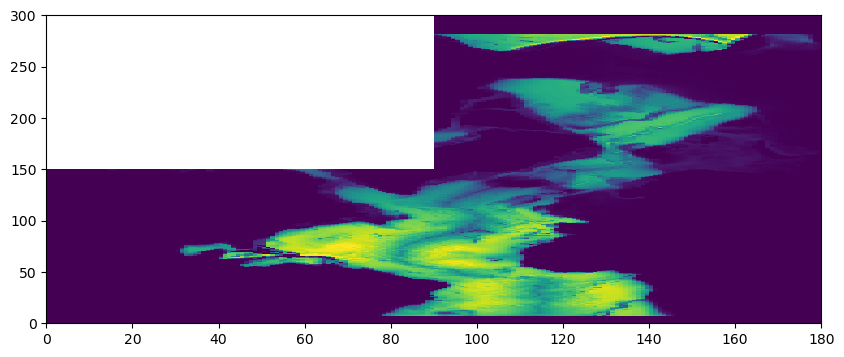

In [61]:
# plt.pcolormesh(dep_aste[0])
plt.pcolormesh(dep_aste[0])

In [62]:
ffac=1e-6
G_T=np.array([])
metaT=parsemeta(layers_path + "diags/LAYERS/layers_3d_Ttend." + "0000000003" + ".meta")
nFldsT = metaT["fldList"]
print(len(nFldsT))
setTtend=nFldsT.copy()
fldsIwant = np.array(['LaTh2TH','LaTz2TH'])

24


In [63]:
# check for the correct diagnostics
metaT['fldList']   # 13, 14, 15, 16, 19, 22
b = metaT['fldList']
ifldT = np.array([1,2])    # surf, hDiff, vDiff, hADV, vADV, total tend
print(np.array(b)[ifldT])  # for G_T

# remake the following to look for the existing terms and see if we can recreate
# ['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'LTha2TH' 'LTza2TH' 'LTto2TH']
ifldT = np.array([0,1,2,7,8,11])
print(np.array(b)[ifldT])  # for G_T

['LaTh2TH' 'LaTz2TH']
['LaTs2TH' 'LaTh2TH' 'LaTz2TH' 'LTha2TH' 'LTza2TH' 'LTto2TH']


In [64]:
filename = "layers2TH"
boundsT = rdmds(layers_path + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

filename = "layers1SLT"
boundsS = rdmds(layers_path + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]

binwidthT1 = (binwidthT[:-1] + binwidthT[1:])/2
binwidthS1 = (binwidthS[:-1] + binwidthS[1:])/2

binmidT = ((boundsT[:-1] + boundsT[1:])/2).reshape(nT)
binmidS = ((boundsS[:-1] + boundsS[1:])/2).reshape(nT)

In [65]:
# 2d
rac2d = read_float64(dirgrid + "RAC" + ".data")
print("RAC2d",rac2d.shape)

drf3d = read_float32(dirgrid + "DRF" + ".data")


rac2dtile = np.tile(rac2d,(nT-1,1)) #.shape

hf1 = mygrid['hFacC'][0] # top layer in z

hf1flat = np.reshape(hf1,hf1.flatten().shape[0])
hf2d = hf1flat

hf2dtile = np.tile(hf2d,(nT-1,1))
ffac = 1e-6

RAC2d (40500,)
(100,)


In [66]:
# we're not using iWetC2d because I'm not sure where this went for the ASTE 90 grid
ts = "0000000003"
tsstr = np.array([ts])

In [67]:
# make the G_T term
G_T = {}
G_T["all"] = {}
    
# now loop through
G_T["all"][ts] = {}
for i in range(len(ifldT)-1, -1, -1):
    tmp = read_float64_skip(layers_path + "diags/LAYERS/layers_3d_Ttend." + tsstr[-1] + ".data", nx*ny*(nT-1),ifldT[i])
    tmp = np.reshape(tmp,(nT-1,nx*ny))
    tmp = tmp * (rac2dtile * hf2dtile) #* ffac

    if i == ifldT.shape[0]-1:
        # if LTto2TH, do not remove from residual
        residT = tmp
    else:
        # else if vADV, hADV, vDiff, hDiff, surface, remove from residual
        residT = residT-tmp
    
    # just do the Barents Sea for this one
    a = np.nansum(tmp,axis=1)
    G_T["all"][ts][setTtend[ifldT[i]]] = a

G_T["all"][ts]["residT"] = np.nansum(residT,axis=1)

In [68]:
# plot this as a line graph with the T bins
h_diff_layers = G_T["all"][ts]['LaTh2TH']
r_diff_layers = G_T["all"][ts]['LaTz2TH']

In [69]:
# make sure we get the dt correct
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = np.array([2.,3.])


dt = ts2dte(fnames[1])-ts2dte(fnames[0])  # days
dt = dt.total_seconds()
dt

1200.0

In [70]:
tsstr = np.array(['0000000002','0000000003'])
t2 = int(tsstr[1])

In [25]:
budgO = {}
budgO['heatfluxes'] = {}

## do the advective convergence
file_name = "budg3d_hflux_set2"
meta_budg3d_hflux_set2 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_hflux_set2["fldList"])
varnames = np.array(["DFxE_TH","DFyE_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
DFxE_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
DFyE_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])


# now 3d zfluxes
file_name = "budg3d_zflux_set1"
meta_budg3d_zflux_set1 = parsemeta(dirdiags + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_budg3d_zflux_set1["fldList"])
varnames = np.array(["DFrE_TH","DFrI_TH"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
DFrE_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[0])
DFrI_TH,its,meta = rdmds(os.path.join(dirdiags, file_name),t2,returnmeta=True,rec=recs[1])
DFrE_TH = DFrE_TH.reshape(nz,ny,nx)
DFrI_TH = DFrI_TH.reshape(nz,ny,nx)

In [32]:
tmpUo = get_aste_faces(DFxE_TH.reshape(nz,ny,nx),nfx,nfy)
tmpVo = get_aste_faces(DFyE_TH.reshape(nz,ny,nx),nfx,nfy)
budgO['heatfluxes']['DF_hconv'] = calc_UV_conv_mod(nfx,nfy,tmpUo,tmpVo) #* myparms['rcp']   # keep in degC.m^3/s

trWtopDF = -(DFrE_TH+DFrI_TH) #* myparms['rcp']  # degC.m^3/s

# do vertical convergence for ADV and DF terms
tmpdf = np.full((nz,ny,nx),np.nan)
tmpdf[:-1,:,:] = (trWtopDF[:-1] - trWtopDF[1:])              # for surface thru seafloor

dfTconv = budgO['heatfluxes']['DF_hconv'] + tmpdf
budgO['heatfluxes']['DF_Tconv'] = dfTconv      # J/s, this is the diffusive arrow of T for a cell

DFh = budgO['heatfluxes']['DF_hconv']
DFr = tmpdf

In [27]:
# we need to also create the theta and salt bins for this area

# 'diags/state_3d_set1'
# read theta and salt averages from the t2 timestep (average)
file_name = "state_3d_set1"
meta_state_3d_set1 = parsemeta(dirstate + file_name + "." + tsstr[0] + ".meta")
fldlist = np.array(meta_state_3d_set1["fldList"])
varnames = np.array(["THETA","SALT"])
recs = np.array([])
for var in varnames:
    irec = np.where(fldlist == var)
    recs = np.append(recs, irec[0][0])
THETA,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[0])
SALT,its,meta = rdmds(os.path.join(dirstate, file_name),t2,returnmeta=True,rec=recs[1])

THETA = THETA.reshape(nz,ny,nx)
SALT = SALT.reshape(nz,ny,nx)

In [37]:

def bin_dF_by_theta(THETA, boundsT, DFh, DFr):
    """
    Replicates the MATLAB loop:
      for i=1:nT
        ij = find(T >= boundsT(i) & T < boundsT(i+1));
        Lij(i)        = length(ij);
        dF_Tcenter(2,i) = sum(DFh(ij));   % degC m^3/s
        dF_Tcenter(3,i) = sum(DFr(ij));   % degC m^3/s
      end
    but using THETA (3D) instead of T, and handling NaNs like MATLAB:
    if any DFh/DFr in a bin are NaN, the sum for that bin is NaN.

    Parameters
    ----------
    THETA  : ndarray (3D or any shape) — binning variable, may contain NaNs
    boundsT: (N+1,)  array of bin edges
    DFh    : ndarray same shape as THETA (degC m^3/s), may contain NaNs
    DFr    : ndarray same shape as THETA (degC m^3/s), may contain NaNs

    Returns
    -------
    Lij      : (N,) int    counts per bin (based on THETA only)
    dFh_bin  : (N,) float  sum of DFh in each bin (NaN if any DFh in bin is NaN)
    DFr_bin  : (N,) float  sum of DFr in each bin (NaN if any DFr in bin is NaN)
    """
    THETA   = np.asarray(THETA)
    boundsT = np.asarray(boundsT)
    DFh     = np.asarray(DFh)
    DFr     = np.asarray(DFr)

    nT = boundsT.size - 1

    # Flatten for vectorized binning
    theta = THETA.ravel()
    dfh   = DFh.ravel()
    dfr   = DFr.ravel()

    # Bin indices for [lower, upper) using np.digitize(..., right=False)
    bin_idx = np.digitize(theta, boundsT, right=False) - 1

    # Valid THETA: finite and within bin range
    valid_theta = np.isfinite(theta) & (bin_idx >= 0) & (bin_idx < nT)
    idx = bin_idx[valid_theta]

    # Lij = count of THETA in each bin (regardless of DFh/DFr NaNs)
    Lij = np.bincount(idx, minlength=nT)

    # ----- DFh sums with MATLAB-like NaN propagation -----
    vals_h = dfh[valid_theta]
    nan_h  = np.isnan(vals_h)

    # Sum the non-NaN values
    sum_h = np.bincount(idx[~nan_h], weights=vals_h[~nan_h], minlength=nT).astype(float)

    # If any NaN occurred in a bin, set that bin's sum to NaN
    any_nan_h = np.bincount(idx[nan_h], minlength=nT) > 0
    sum_h[any_nan_h] = np.nan
    dFh_bin = sum_h

    # ----- DFr sums with MATLAB-like NaN propagation -----
    vals_r = dfr[valid_theta]
    nan_r  = np.isnan(vals_r)

    sum_r = np.bincount(idx[~nan_r], weights=vals_r[~nan_r], minlength=nT).astype(float)
    any_nan_r = np.bincount(idx[nan_r], minlength=nT) > 0
    sum_r[any_nan_r] = np.nan
    DFr_bin = sum_r

    return Lij, dFh_bin, DFr_bin

In [38]:
Lij, df_hconv_binned, df_rconv_binned = bin_dF_by_theta(THETA, boundsT[:,0,0], DFh, DFr)


In [42]:
dfT_edge = (df_hconv_binned[:-1]+df_hconv_binned[1:])/2
G_T_offline = dfT_edge / binwidthT1
G_T_offline_center = df_hconv_binned / binwidthT

In [74]:
dfT_edge.shape

(111,)

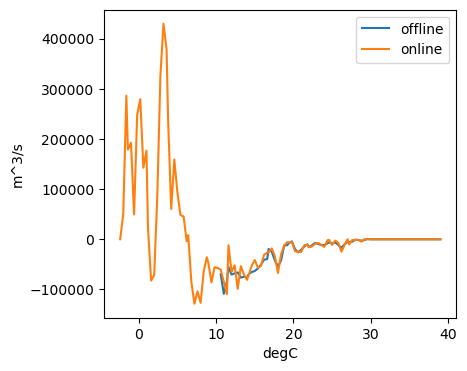

In [73]:
fig = plt.figure()

ax = plt.subplot(121)
ax.plot(boundsT[:,0,0][1:-1],G_T_offline,label="offline")
ax.plot(boundsT[:,0,0][1:-1],h_diff_layers,label="online")
ax.set_ylabel("m^3/s")
ax.set_xlabel("degC")
ax.legend(loc="best")